# EUREC4A platforms and the meso-scale organization
This notebook illustrates how the Level3 data can be used to put the wide-range of research platforms into context of the meso-scale organization. Depending on their track and location, the meso-scale organization they were situated in varied.

The timeseries of RV Meteor, Barbados Cloud Observatory and RV Atalante are shown below and can be easily adapted for other platforms.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Workflow as given in l3 output
workflow = 'IR'
mode = 'daily'

# Level3 filename (input)
level3_file = '../processed_data/EUREC4A_ManualClassifications_l3_{workflow}_{mode}.zarr'.format(workflow=workflow, mode=mode)

# DSHIP Meteor (input)
meteor_dship_file = 'https://observations.ipsl.fr/thredds/dodsC/EUREC4A/PRODUCTS/TRACKS/EUREC4A_tracks_Meteor_v1.0.nc'

# Figure directory (output)
outdir = '../figures/'

In [3]:
ds = xr.open_zarr(level3_file)

<ipython-input-3-7a910d81195f>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(level3_file)


In [4]:
color_dict = {'Flowers':'#2281BB',
              'Fish': '#93D2E2',
              'Gravel': '#3EAE47',
              'Sugar': '#A1D791'}

In [5]:
ds

<xarray.Dataset>
Dimensions:    (date: 47, longitude: 2200, latitude: 1500, pattern: 4)
Coordinates:
  * date       (date) datetime64[ns] 2020-01-07 2020-01-08 ... 2020-02-22
  * latitude   (latitude) float64 20.0 19.99 19.98 19.97 ... 5.03 5.02 5.01 5.0
  * longitude  (longitude) float64 -62.0 -61.99 -61.98 ... -40.02 -40.01 -40.0
  * pattern    (pattern) object 'Sugar' 'Flowers' 'Fish' 'Gravel'
Data variables:
    freq       (date, longitude, latitude, pattern) float64 dask.array<chunksize=(1, 2200, 1500, 4), meta=np.ndarray>
    nb_users   (date) float64 dask.array<chunksize=(47,), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2021-11-24 00:58 UTC
    created_with:    create_level3.py with its last modification on Wed Nov 2...
    description:     Level-3: daily classification frequency
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    version:         --

In [6]:
if mode == 'daily':
    data = ds.freq.sel(latitude=13.1626389, longitude=-059.4287500, method='nearest')
    data2 = data
elif mode =='instant':
    data=(ds.freq.sel(latitude=13.1626389, longitude=-059.4287500, method='nearest') * ds.nb_users).groupby(ds.date.dt.date).mean().compute()
    data2 = data/ds.nb_users.groupby(ds.date.dt.date).mean().compute()

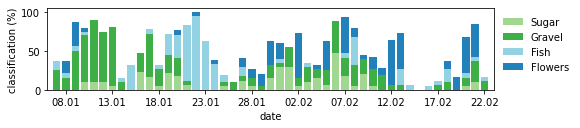

In [9]:
frequency = np.zeros((len(data2.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
    data_ = data2.sel(pattern=p).values *100
    data_[np.isnan(data_)] = 0
    ax.bar(dates.date2num(data.date), data_, label=p, bottom=frequency, color=color_dict[p])
    frequency += data_
    hfmt = dates.DateFormatter('%d.%m')
    ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(hfmt)
plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
plt.savefig(outdir+'ManualClassification_BCO_{}_{}.pdf'.format(workflow,mode),bbox_inches='tight')

In [7]:
ds_meteor = xr.open_dataset(meteor_dship_file, engine="netcdf4")

In [8]:
ds_meteor

<xarray.Dataset>
Dimensions:  (time: 47520)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-18 ... 2020-02-19T23:59:00
Data variables:
    lat      (time) float32 ...
    lon      (time) float32 ...
    alt      (time) float32 ...
Attributes: (12/13)
    history:                         Created from source   by B Stevens (bjor...
    title:                           Trajectory from Meteor position data
    campaign:                        EUREC4A
    platform:                        Meteor
    product:                         tracks
    Conventions:                     CF-1.8
    ...                              ...
    source:                          EUREC4A_DSHIP_Meteor_v1.00.nc
    featureType:                     trajectory
    version:                         v1.0
    contact:                         Wiebke Mohr, email: wmohr@mpi-bremen.de;...
    doi:                             10.25326/165
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
# Make coordinates data variables
ds_meteor['latitude'] = xr.DataArray(ds_meteor.lat.values, dims=['time'])
ds_meteor['longitude'] = xr.DataArray(ds_meteor.lon.values, dims=['time'])

In [10]:
ds_meteor_daily = ds_meteor.resample(time='1D').mean() # Attention, only works as long as the equator and 0 meridian are not crossed

In [12]:
if mode == 'daily':
    ds_classifications_daily = ds.freq
elif mode =='instant':
    ds_classifications_daily = (ds.freq * ds.nb_users).groupby(ds.date.dt.date).mean() / ds.nb_users.groupby(ds.date.dt.date).mean()

(18267.0, 18315.0)

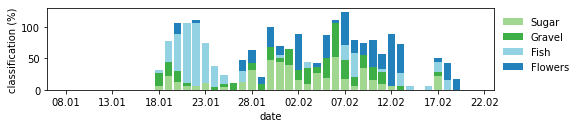

In [15]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(ds_meteor_daily.time):
    frequency = 0
    lat = ds_meteor_daily.latitude.sel(time=date)
    lon = ds_meteor_daily.longitude.sel(time=date)
    if mode == 'daily':
        date_to_sel = date
    elif mode =='instant':
        date_to_sel = date.dt.date
    for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
        try:
            data = ds_classifications_daily.sel(latitude=lat, longitude=lon, method='nearest').sel(date=date_to_sel, pattern=p).values *100
        except KeyError:
            print('No data found for date {}'.format(date))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
# plt.savefig(outdir+'ManualClassification_Meteor_{}.pdf'.format(workflow),bbox_inches='tight')

In [16]:
pwd

'/mnt/lustre02/work/mh0010/m300408/EUREC4A_CloudClassification/manual/EUREC4A_manualclassifications/notebooks'

In [17]:
!which python

/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/bin/python


## Atalante

In [18]:
import pandas as pd
import datetime as dt

In [19]:
ds_atalante = xr.open_dataset("https://observations.ipsl.fr/thredds/dodsC/EUREC4A/PRODUCTS/TRACKS/EUREC4A_tracks_Atalante_v1.0.nc")

In [22]:
ds_atalante_daily = ds_atalante.resample(time='1D').mean()

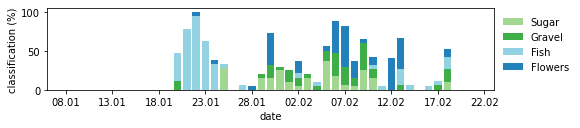

In [23]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(ds_atalante_daily.sel(time=slice(dt.datetime(2020,1,20),dt.datetime(2020,2,18))).time):
    frequency = 0
    lat = ds_atalante_daily.lat.sel(time=date)
    lon = ds_atalante_daily.lon.sel(time=date)
    if np.isnan(lat) or np.isnan(lon):
        print('Position contains nan on {}'.format(date.values))
        continue
    for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
#         if mode =='daily':
            
#         elif mode =='instant':
            
        try:
            data = ds.freq.sel(date=date, pattern=p).interp(coords={'latitude':lat, 'longitude':lon}, kwargs={'bounds_error':True}).values *100
        except KeyError:
            print('No data found for date {}'.format(date.values))
            break
        except ValueError:
            print('Platform is outside of domain on {}: {},{}'.format(date.values, lat.values, lon.values))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
plt.savefig(outdir+'ManualClassification_Atalante_{}_{}.pdf'.format(workflow,mode),bbox_inches='tight')